# Analysis of miRNA Regulation in Single Cells
---

### Wendao Liu

In [1]:
# Suppress warnings
options(warn = -1)

# Content
#### [1  Introduction](#1)
   * [1.1 Prepare data](#1.1)
   * [1.2 Import data](#1.2)
   
#### [2 Estimate Expression Levels and Noises of mRNAs](#2)
   * [2.1 Calculate mean and SD of RPKM](#2.1)
   * [2.2 Calculate Residual SD of RPKM](#2.2)

#### [3 Measure miRNA Regulation](#3)
   * [3.1 Predict target genes of miRNAs](#3.1)
   * [3.2 Divide miRNAs into groups by expression levels ](#3.2)
   * [3.3 Visualize results](#3.3)

#### [4 Using Deep Count Autoencoder to Denoise Gene Expression Matrix](#4)
   * [4.1 Install and run DCA](#4.1)
   * [4.2 Process DCA output](#4.2)
   * [4.3 Perform analysis with DCA normalized counts](#4.3)

#### [5 Session Information](#5)

<h2 id="1"> 1 Intrduction </h2>

MicroRNAs (miRNAs) regulate gene expression by binding to mRNAs, and consequently reduce target gene expression levels and expression variability, which is also known as ‘noise’. Single-cell sequencing technology now enables profiling mRNA and miRNA expression in single cells. With this technology, we are able to better quantify gene expression noise by measuring cell-to-cell variability, and therefore analyze how miRNAs regulate the expression of their target genes.

This vignette will demonstrate an analysis workflow using [R programming language](https://www.r-project.org/) for miRNA regulation in single cells.

<h3 id="1.1"> 1.1 Prepare data </h3>

We will use [TargetScan](www.targetscan.org) to predict the target genes of miRNAs. The following data are needed in the analysis.

* Predicted target genes of miRNA families from TargetScan. http://www.targetscan.org/vert_72/vert_72_data_download/Predicted_Targets_Info.default_predictions.txt.zip 
* Information of miRNAs and their families from TargetScan. http://www.targetscan.org/vert_72/vert_72_data_download/miR_Family_Info.txt.zip 

We will illustrate the workflow with a dataset from [Wang et al. 2019](https://doi.org/10.1038/s41467-018-07981-6). They performed co-sequencing of miRNAs and mRNAs in same K562 single cells using a half-cell genomics approach. The dataset is available at [GSE114071](https://www.ncbi.nlm.nih.gov/geo/query/acc.cgi?acc=GSE114071). It contains mRNA and miRNA sequencing results of 19 successfully profiled single cells. Single-cell mRNA sequencing is performed using [Smart-seq](https://doi.org/10.1038/nmeth.2639) protocol.

* miRNA expression matrix from dataset GSE114071. https://www.ncbi.nlm.nih.gov/geo/download/?acc=GSE114071&format=file&file=GSE114071%5FNW%5FscsmRNA%5FK562%5Fnorm%5Flog2%2Egct%2Egz 

Unluckily, raw read count matrix of mRNA is not provided in this dataset, which is required in our analysis. Therefore, we quantified gene expression from [raw sequencing files](https://trace.ncbi.nlm.nih.gov/Traces/study/?acc=SRP144659&f=assay_type_s%3An%3Arna-seq%3Ac&o=acc_s%3Aa) using RSEM, with [GENCODE v27 annotation](https://www.gencodegenes.org/human/release_27.html). RSEM is a popular software for accurately quantifying gene and transcript expression levels from RNA-Seq data. The algorithm is described in [Li et al. 2011](https://doi.org/10.1186/1471-2105-12-323), and its detailed usage is available on [Github](https://github.com/deweylab/RSEM).

The following tables generated by RSEM, along with a copy of other data are available in [this Github repository](https://github.com/liuwd15/sc-miReg/tree/master/data).

* mRNA raw read count matrix of dataset GSE114071. https://raw.githubusercontent.com/liuwd15/sc-miReg/master/data/GSE114071_count.tsv
* mRNA RPKM matrix of dataset GSE114071. https://raw.githubusercontent.com/liuwd15/sc-miReg/master/data/GSE114071_rpkm.tsv
* DCA normalized count matrix of dataset GSE114071. https://raw.githubusercontent.com/liuwd15/sc-miReg/master/data/GSE114071_dca.tsv
* Effective gene length matrix of dataset GSE114071. https://raw.githubusercontent.com/liuwd15/sc-miReg/master/data/GSE114071_length.tsv

<h3 id="1.2"> 1.2 Import data </h3>

Read miRNA expression matrix. After removing redundant columns, the first column shows the name of miRNAs and column 2~20 correspond to 19 successfully profiled single cells (K562_HalfCell_01 ~ K562_HalfCell_20 excluding K562_HalfCell_06, because it did not pass quality control). 

Please note that values in the matrix are normalized read counts. The raw read count of a miRNA is divided by the library size, applied with a minimum expression level of $10^{-4}$ (i.e. values less than $10^{-4}$ were set to $10^{-4}$), and log2-transformed to get the normalized read count. We call this normalized read count **'log2 fraction'**. The minimun value in the matrix is $$\log_2(10^{-4})=-13.287712$$

In [2]:
mirna <- read.table('GSE114071_NW_scsmRNA_K562_norm_log2.gct', header=T, stringsAsFactors=F)
mirna <- mirna[,c(1,3:21)]    # Column 2 containing descriptions is removed
head(mirna)

Name,K562_HalfCell_01,K562_HalfCell_02,K562_HalfCell_03,K562_HalfCell_04,K562_HalfCell_05,K562_HalfCell_07,K562_HalfCell_08,K562_HalfCell_09,K562_HalfCell_10,K562_HalfCell_11,K562_HalfCell_12,K562_HalfCell_13,K562_HalfCell_14,K562_HalfCell_15,K562_HalfCell_16,K562_HalfCell_17,K562_HalfCell_18,K562_HalfCell_19,K562_HalfCell_20
hsa-let-7a-5p,-7.596052,-7.701645,-8.32782,-8.071105,-8.531938,-8.530875,-8.598833,-8.760631,-7.868867,-8.212063,-8.275806,-8.253923,-8.142078,-7.951609,-8.676871,-7.638568,-8.237843,-8.525456,-8.422284
hsa-let-7a-3p,-13.287712,-13.287712,-13.28771,-13.287712,-13.287712,-13.287712,-13.287712,-13.287712,-13.287712,-13.287712,-13.287712,-13.287712,-13.287712,-13.287712,-13.287712,-13.287712,-13.287712,-13.287712,-13.287712
hsa-let-7a-5p,-7.596052,-7.701645,-8.32782,-8.071105,-8.531938,-8.530875,-8.598833,-8.760631,-7.868867,-8.212063,-8.275806,-8.319346,-8.142078,-7.951609,-8.676871,-7.638568,-8.237843,-8.525456,-8.422284
hsa-let-7a-2-3p,-13.287712,-13.287712,-13.28771,-13.287712,-13.287712,-13.287712,-13.287712,-13.287712,-13.287712,-13.287712,-13.287712,-13.287712,-13.287712,-13.287712,-13.287712,-13.287712,-13.287712,-13.287712,-13.287712
hsa-let-7a-5p,-7.596052,-7.701645,-8.32782,-8.071105,-8.531938,-8.530875,-8.598833,-8.760631,-7.868867,-8.212063,-8.275806,-8.319346,-8.142078,-7.951609,-8.676871,-7.638568,-8.237843,-8.525456,-8.422284
hsa-let-7a-3p,-13.287712,-13.287712,-13.28771,-13.287712,-13.287712,-13.287712,-13.287712,-13.287712,-13.287712,-13.287712,-13.287712,-13.287712,-13.287712,-13.287712,-13.287712,-13.287712,-13.287712,-13.287712,-13.287712


Read mRNA expression matrix. The values in the matrix are RPKM values. We match the columns of this matrix to the columns of miRNA expression matrix, such that column 2~20 correspond to 19 successfully profiled single cells.

In [3]:
mrna_rpkm <- read.table('GSE114071_RPKM.tsv', header=T, stringsAsFactors=F)
# We retain 19 successfully profiled single cells, excluding K562_HalfCell_06
mrna_rpkm <- mrna_rpkm[,c(1:6,8:21)]
colnames(mrna_rpkm) <- colnames(mirna)
head(mrna_rpkm)

Name,K562_HalfCell_01,K562_HalfCell_02,K562_HalfCell_03,K562_HalfCell_04,K562_HalfCell_05,K562_HalfCell_07,K562_HalfCell_08,K562_HalfCell_09,K562_HalfCell_10,K562_HalfCell_11,K562_HalfCell_12,K562_HalfCell_13,K562_HalfCell_14,K562_HalfCell_15,K562_HalfCell_16,K562_HalfCell_17,K562_HalfCell_18,K562_HalfCell_19,K562_HalfCell_20
A1BG,1.57,3.29,2.61,1.06,1.60,3.37,2.08,2.71,0.00,1.66,3.65,1.58,1.31,2.83,4.33,2.25,1.29,3.03,1.95
A1BG-AS1,3.64,0.00,0.48,0.70,0.00,0.00,0.00,1.16,1.36,2.27,1.77,1.17,0.00,0.00,3.33,0.00,0.35,2.49,0.15
A1CF,0.00,0.00,0.00,0.00,0.19,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00
A2M,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00
A2M-AS1,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00
A2ML1,0.00,0.00,0.00,0.00,0.00,0.00,0.10,0.29,0.00,0.00,0.45,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00


Read target prediction table from TargetScan. We will use `family_info` to get the miRNA family of each miRNA, and `TS` to get the predicted target genes of each miRNA family.

In [4]:
# TargetScan prediction
TS <- read.table('Predicted_Targets_Info.default_predictions.txt', header=T, sep='\t', stringsAsFactors=F)
family_info <- read.table('miR_Family_Info.txt', header=T, sep='\t', stringsAsFactors=F)

<h2 id="2"> 2 Estimate Expression Levels and Noises of mRNAs </h2>

In this section, we are going to estimate the expression levels (average expression) and expression noises (the variability of expression) of mRNAs in single cells with RPKM values. 

<h3 id="2.1"> 2.1 Calculate mean and SD of RPKM </h3>

To get an accurate estimate of mean and variability, mRNAs expressed in less than 5 single cells are filtered out.

In [5]:
# Column 2~20 correspond to 19 single cells
index_cells <- 2:20

# We retained mRNAs expressed in no less than 5 single cells.
gene_filt <- which(apply(mrna_rpkm[,index_cells] > 0, 1, sum) >= 5)

The most common measure to quantify the variability of a random variable is standard deviation (SD). Here, we first calculate the mean and SD of the expression levels of mRNAs. The meta data of retained mRNAs are saved in dataframe `meta`.

In [6]:
meta <- data.frame(gene=mrna_rpkm[gene_filt, 'Name'])                        # Gene name
meta$mean_rpkm <- apply(mrna_rpkm[gene_filt, index_cells], 1, mean)          # Mean RPKM
meta$sd_rpkm <- apply(mrna_rpkm[gene_filt, index_cells], 1, sd)              # SD RPKM

<h3 id="2.2"> 2.2 Calculate Residual SD of RPKM </h3>

Unluckily, SD is not a good measure to quantify expression noises of mRNAs in single cells. This is because SD RPKM values generally tend to increase when mean RPKM values increase in single cells. In other word, mean RPKM and SD RPKM are not *independent*. Here we can see that mean RPKM and SD RPKM values have a strong linear correlation on a logarithmic scale  ($R^2=0.947$).

In [7]:
# Linear regression model for log SD RPKM and log mean RPKM
fit <- lm(log10(sd_rpkm) ~ log10(mean_rpkm), meta)
summary(fit)


Call:
lm(formula = log10(sd_rpkm) ~ log10(mean_rpkm), data = meta)

Residuals:
     Min       1Q   Median       3Q      Max 
-0.52962 -0.09515 -0.00499  0.08809  1.00247 

Coefficients:
                 Estimate Std. Error t value Pr(>|t|)    
(Intercept)      0.054834   0.001690   32.44   <2e-16 ***
log10(mean_rpkm) 0.688988   0.001425  483.57   <2e-16 ***
---
Signif. codes:  0 '***' 0.001 '**' 0.01 '*' 0.05 '.' 0.1 ' ' 1

Residual standard error: 0.1431 on 13079 degrees of freedom
Multiple R-squared:  0.947,	Adjusted R-squared:  0.947 
F-statistic: 2.338e+05 on 1 and 13079 DF,  p-value: < 2.2e-16


We can also visualize the result using ggplot2. The red line in the plot below represents the ordinary least squares (OLS) linear regression model, and the blue line represents a smooth curve fitted by Generalized Additive Models (GAM). The linear model fits well with data. Apparant discrepancy between two curves is only observed at two sides.

`geom_smooth()` using method = 'gam' and formula 'y ~ s(x, bs = "cs")'


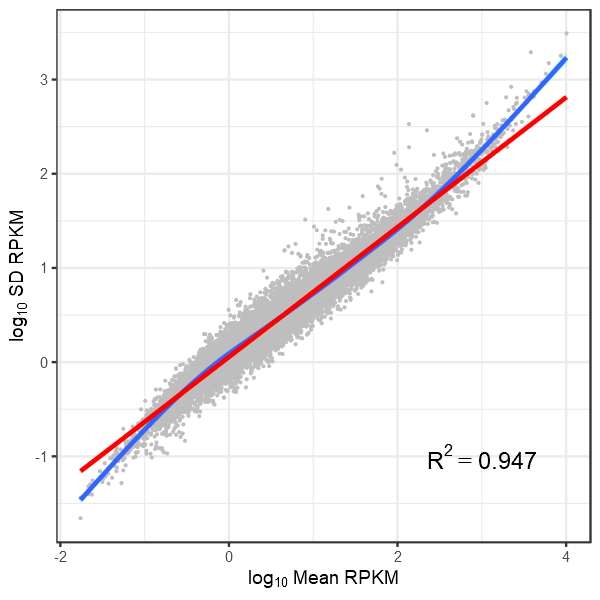

In [8]:
# Load required package for plotting and set plot size
library(ggplot2)
options(repr.plot.width=5, repr.plot.height=5)

ggplot(meta, aes(x=log10(mean_rpkm), y=log10(sd_rpkm))) + 
    geom_point(color='gray', size=0.1) +
    geom_smooth(fill='cyan', size=1) + 
    geom_smooth(method=lm, color='red', fill='pink', size=1) +
    labs(x=expression(log[10]~'Mean RPKM'), y=expression(log[10]~'SD RPKM')) +
    annotate('text', x=3, y=-1, label=expression(R^2==0.947), size=5) + 
    theme_bw()

If we use SD RPKM values as expression noises of mRNAs, highly expressed mRNAs will always have higher expression noises. This is undesirable, because in this way we cannot separately measure miRNAs' regulative effect on target genes' expression levels and noises. Therefore we have to account for the effect of mean RPKM on SD RPKM. 

**Residual SDs** are defined as the residuals of the linear model after 'regressing out' mean RPKM. 
$$Residual\ SD=SD\ RPKM-\hat{SD\ RPKM}$$
where $\hat{SD\ RPKM}$ is the fitted value from the linear model.
A Residual SD measures the relative noise of a mRNA compared to the mean noise of mRNAs at a same expression level. It is not linearly correlated with mean RPKM so we would like to use it as the expression noise.

In [9]:
# Calculate Residual SD
meta$rsd_rpkm <- fit$residuals

`geom_smooth()` using method = 'gam' and formula 'y ~ s(x, bs = "cs")'


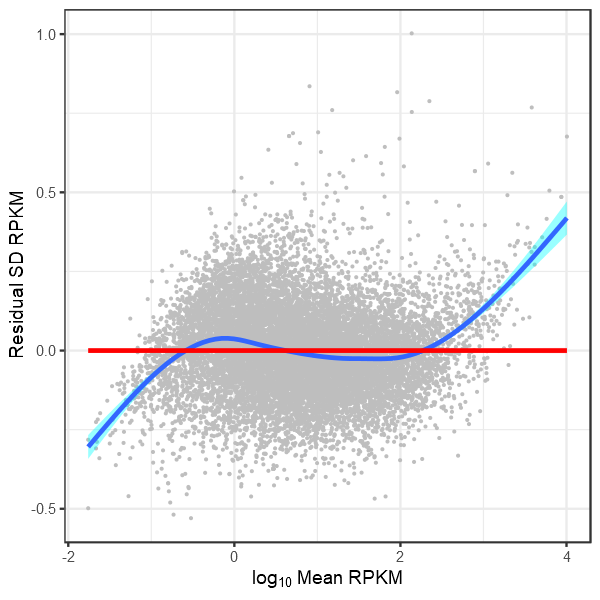

In [10]:
ggplot(meta, aes(x=log10(mean_rpkm), y=rsd_rpkm)) + 
    geom_point(color='gray', size=0.1) +
    geom_smooth(fill='cyan', size=1) + 
    geom_smooth(method=lm, color='red', fill='pink', size=1) +
    labs(x=expression(log[10]~'Mean RPKM'), y='Residual SD RPKM') +
    theme_bw()

In summary, we will use **mean RPKM** values (`meta$mean_rpkm`) as expression levels and **Residual SD RPKM** values (`meta$rsd_rpkm`) as expression noise of mRNAs in the following analysis.

<h2 id="3"> 3 Measure miRNA Regulation </h2>

<h3 id="3.1"> 3.1 Predict target genes of miRNAs </h3>

After quantifying the expression levels and noises of mRNAs, we are going to measure how miRNAs regulate target mRNAs' expression levels and noises. Here we define a function `mir2meta_var` to get the target mRNAs' expression levels and noises of any miRNA. As TargetScan predicts target mRNAs by miRNA families, we first obtain the families of miRNAs, and then get target mRNAs. Finally, we retrieve the expression levels or noises of target mRNAs from dataframe `meta`. 

In [11]:
# Get the target mRNAs' expression levels and noises of miRNAs
# mir: vector of string, miRNA names
# meta_var: string, a variable saved in dataframe meta. 

mir2meta_var <- function(mir, meta_var) 
{
    # Convert miRNAs into miRNA families
    mirna_family <- family_info[family_info$MiRBase.ID %in% mir, 'miR.family']
    
    # Predict target mRNAs of miRNA families
    mirna_target <- unique(TS[TS$miR.Family %in% mirna_family, 'Gene.Symbol'])
    
    # Get the expression levels or noises of target mRNAs calculated above
    target_meta_var <- meta[meta$gene %in% mirna_target, meta_var]
    
    return(target_meta_var)
}

<h3 id="3.2"> 3.2 Divide miRNAs into groups by expression levels </h3>

We assume that highly expressed miRNAs will be more likely to regulate their target mRNAs. Therefore, we divide miRNAs into four groups according to their expression levels:
* Background: $0.0001$ < mean fraction in single cells $\leq 2^{-12} \approx 0.000244$
* Lowly expressed (LE): $2^{-12}$ < mean fraction in single cells $\leq 2^{-9} \approx 0.001953$
* Mediumly expressed (ME): $2^{-9}$ < mean fraction in single cells $\leq 2^{-6} = 0.015625$
* Highly expressed (HE): mean fraction in single cells $>2^{-6} = 0.015625$

For miRNAs in each group, we get their target mRNAs' expression levels and noises using the function `mir2meta_var` defined above.

In [12]:
# Calculate the mean expression levels of miRNAs
mirna_mean <- apply(mirna[,index_cells], 1, mean)

# Divide miRNAs into four groups according to their expression levels, and get expression levels (mean RPKM) in different groups
min_expression <- min(mirna[,-1])
level_background <- mir2meta_var(mirna[mirna_mean > min_expression & mirna_mean <= -12, 1], 'mean_rpkm')
level_LE_mirna <- mir2meta_var(mirna[mirna_mean > -12 & mirna_mean <= -9, 1], 'mean_rpkm')
level_ME_mirna <- mir2meta_var(mirna[mirna_mean > -9 & mirna_mean <= -6, 1], 'mean_rpkm')
level_HE_mirna <- mir2meta_var(mirna[mirna_mean > -6, 1], 'mean_rpkm')

# Divide miRNAs into four groups according to their expression levels, and get expression noises (RCV RPKM) in different groups
noise_background <- mir2meta_var(mirna[mirna_mean > min_expression & mirna_mean <= -12, 1], 'rsd_rpkm')
noise_LE_mirna <- mir2meta_var(mirna[mirna_mean > -12 & mirna_mean <= -9, 1], 'rsd_rpkm')
noise_ME_mirna <- mir2meta_var(mirna[mirna_mean > -9 & mirna_mean <= -6, 1], 'rsd_rpkm')
noise_HE_mirna <- mir2meta_var(mirna[mirna_mean > -6, 1], 'rsd_rpkm')

Here we can check the numbers of miRNAs and target mRNAs in each group, which are saved in a dataframe `group_size`.

In [13]:
# In this dataframe, each row contains the name of a group, the number of miRNA and the number of target mRNA in the group. 
group_size <- data.frame(mirna_expression=c('background','LE','ME','HE'), 
                         mirna_number=c(sum(mirna_mean > min_expression & mirna_mean <= -12), sum(mirna_mean > -12 & mirna_mean <= -9), sum(mirna_mean > -9 & mirna_mean <= -6), sum(mirna_mean > -6)),
                         target_number=c(length(level_background), length(level_LE_mirna), length(level_ME_mirna), length(level_HE_mirna)))
group_size

mirna_expression,mirna_number,target_number
background,210,6201
LE,31,4914
ME,19,3632
HE,5,1144


Now we are ready to examine how miRNAs regulate their target mRNAs' expression. We assume that the regulative effect of miRNAs globally depends on their expression levels, so we are going to compare the distribution of expression levels and noises of target mRNAs in different groups. These data are saved in a dataframe `meta_var_df`.

In [14]:
# In this dataframe, each row contains the group of a target mRNA, its expression level and expression noise. 
meta_var_df <- data.frame(group=rep(group_size$mirna_expression, group_size$target_number),
                          level=c(level_background, level_LE_mirna, level_ME_mirna, level_HE_mirna),
                          noise=c(noise_background, noise_LE_mirna, noise_ME_mirna, noise_HE_mirna))

We can use Kruskal–Wallis test to test whether target mRNAs' expression levels or noises in different groups are from the same distributions. Here the small P-values strongly support the alternative hypothesis: Target mRNAs' expression levels or noises in different groups are from different distributions.

In [15]:
kruskal.test(level ~ group, data = meta_var_df) 
kruskal.test(noise ~ group, data = meta_var_df) 


	Kruskal-Wallis rank sum test

data:  level by group
Kruskal-Wallis chi-squared = 44.433, df = 3, p-value = 1.221e-09



	Kruskal-Wallis rank sum test

data:  noise by group
Kruskal-Wallis chi-squared = 24.415, df = 3, p-value = 2.046e-05


To determine the statistical significance of difference between expression levels and noises from any two groups, we use Kolmogorov–Smirnov (KS) test to get the P-values and save them in a dataframe `p_df`.

In [16]:
# In this dataframe, each row contains names of two groups, statistical significance of difference between expression levels and noises from two groups. 
p_df <- data.frame(x=c('background', 'background', 'background', 'LE', 'LE', 'ME'),       # group A
                   y=c('LE', 'ME', 'HE', 'ME', 'HE', 'HE'),                               # group B
                   p_level=c(ks.test(level_background, level_LE_mirna)$p.value,                
                             ks.test(level_background, level_ME_mirna)$p.value,
                             ks.test(level_background, level_HE_mirna)$p.value,
                             ks.test(level_LE_mirna, level_ME_mirna)$p.value,
                             ks.test(level_LE_mirna, level_HE_mirna)$p.value,
                             ks.test(level_ME_mirna, level_HE_mirna)$p.value),
                   p_noise=c(ks.test(noise_background, noise_LE_mirna)$p.value,                
                             ks.test(noise_background, noise_ME_mirna)$p.value,
                             ks.test(noise_background, noise_HE_mirna)$p.value,
                             ks.test(noise_LE_mirna, noise_ME_mirna)$p.value,
                             ks.test(noise_LE_mirna, noise_HE_mirna)$p.value,
                             ks.test(noise_ME_mirna, noise_HE_mirna)$p.value))

<h3 id="3.3"> 3.3 Visualize results </h3>

Now we are going to visualize results obtained above. We use empirical cumulative distribtion functions (ECDFs) to show the distributions of target mRNAs' expression levels and noises (left plots), and heatmap to show statistical significance between any two groups (right plots).

In left plots, each line corresponds to the ECDF of target mRNAs' expression levels or noises in each group. The leftmost line corresponds to the group with the lowest overall expression levels or noises. 

In right plots, $-log_{10}$ P values from KS-tests are labeled to show the statistical significance.

Loading required package: magrittr


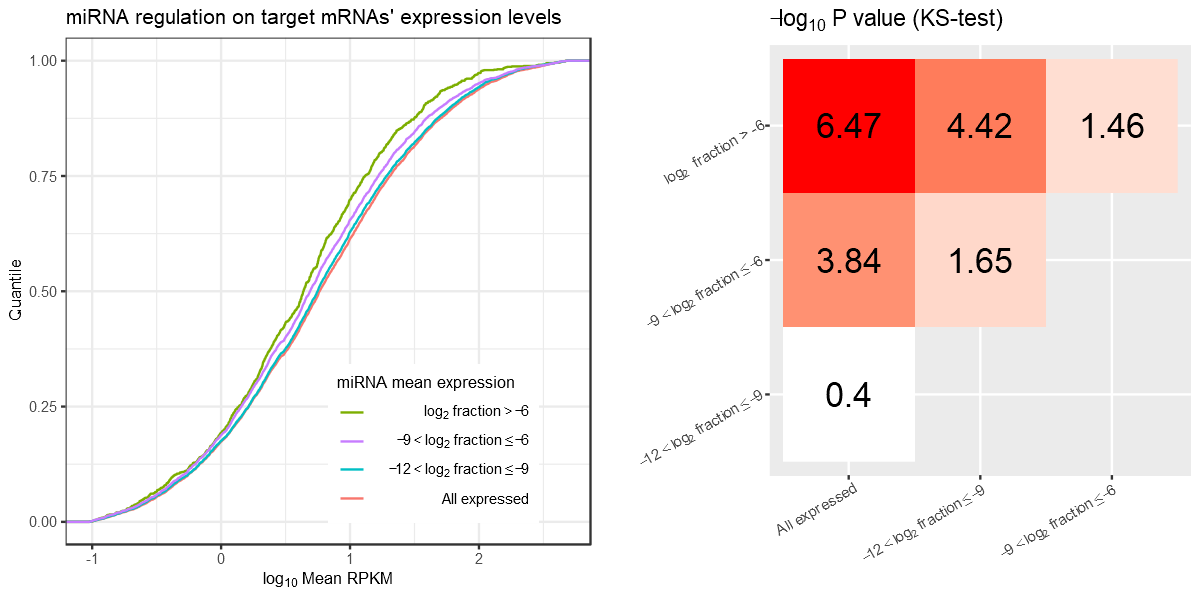

In [17]:
library(ggpubr)
options(repr.plot.width=10, repr.plot.height=5)

plot_ecdf <- ggplot(meta_var_df, aes(x=log10(level), color=group)) + 
             stat_ecdf(geom = "step") + 
             lims(x=quantile(log10(meta_var_df$level),c(0.01,0.99))) + 
             labs(x=expression(log[10]~'Mean RPKM') ,y='Quantile', title="miRNA regulation on target mRNAs' expression levels") + 
             scale_color_discrete(breaks=c('HE','ME','LE','background'), 
                                  name='miRNA mean expression',
                                  labels=expression(log[2]~fraction > -6, -9 < log[2]~fraction <= -6, -12 < log[2]~fraction <= -9, 'All expressed')) + 
             theme_bw() + 
             theme(legend.position=c(0.7,0.2), title=element_text(size=10))
    
plot_p <- ggplot(p_df,aes(x=x,y=y)) + 
          geom_raster(aes(fill = -log10(p_level))) + 
          geom_text(aes(label = round(-log10(p_level),2)), size=7) + 
          scale_fill_gradient(low = "white", high = "red") + 
          scale_x_discrete(limits=c('background','LE','ME'), labels=expression('All expressed', -12 < log[2]~fraction <= -9, -9 < log[2]~fraction <= -6)) + 
          scale_y_discrete(limits=c('LE','ME','HE'), labels=expression(-12 < log[2]~fraction <= -9, -9 < log[2]~fraction <= -6, log[2]~' fraction > -6')) +
          labs(x='',y='',title=expression(-log[10]~'P value (KS-test)')) + 
          theme(legend.position = 'none', axis.text = element_text(angle=30, hjust=1))
          
ggarrange(plot_ecdf, plot_p)

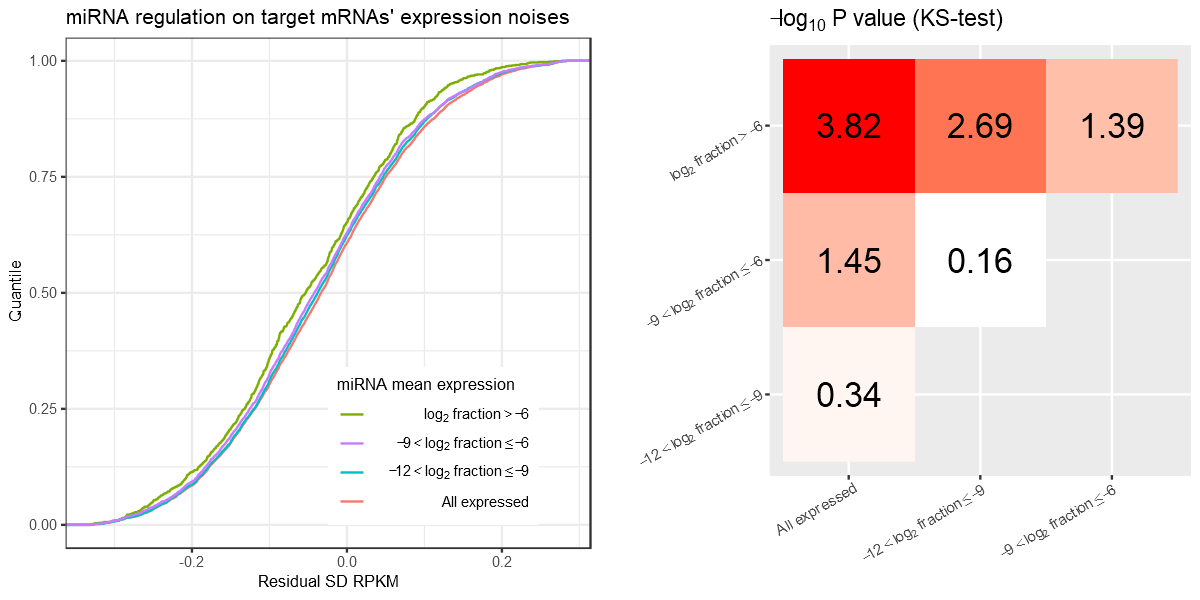

In [18]:
plot_ecdf <- ggplot(meta_var_df, aes(x=noise, color=group)) + 
             stat_ecdf(geom = "step") + 
             lims(x=quantile(meta_var_df$noise,c(0.01,0.99))) + 
             labs(x='Residual SD RPKM' ,y='Quantile', title="miRNA regulation on target mRNAs' expression noises") + 
             scale_color_discrete(breaks=c('HE','ME','LE','background'), 
                                  name='miRNA mean expression',
                                  labels=expression(log[2]~fraction > -6, -9 < log[2]~fraction <= -6, -12 < log[2]~fraction <= -9, 'All expressed')) +
             theme_bw() + 
             theme(legend.position=c(0.7,0.2), title=element_text(size=10))

plot_p <- ggplot(p_df,aes(x=x,y=y)) + 
          geom_raster(aes(fill = -log10(p_noise))) + 
          geom_text(aes(label = round(-log10(p_noise),2)), size=7) + 
          scale_fill_gradient(low = "white", high = "red") + 
          scale_x_discrete(limits=c('background','LE','ME'), labels=expression('All expressed', -12 < log[2]~fraction <= -9, -9 < log[2]~fraction <= -6)) + 
          scale_y_discrete(limits=c('LE','ME','HE'), labels=expression(-12 < log[2]~fraction <= -9, -9 < log[2]~fraction <= -6, log[2]~fraction > -6)) +
          labs(x='',y='',title=expression(-log[10]~'P value (KS-test)')) + 
          theme(legend.position = 'none', axis.text = element_text(angle=30, hjust=1))
          
ggarrange(plot_ecdf, plot_p)

From plots above, we can see that ECDF lines from left to the right are always: green-purple-blue-red. P-values show that mRNAs targeted by highly expressed miRNAs have significantly lower expression levels and noises than those of lowly expressed miRNAs. This suggest that **the overall expression levels and noises of target mRNAs tend to decrease as miRNA mean expression level increases**. In other word, **miRNAs regulate their target mRNAs by reducing their expression levels and noises**.

<h2 id="4"> 4 Using Deep Count Autoencoder to denoise gene expression matrix </h2>

Despite single-cell sequencing has many strengths, various technical factors like amplification bias, library size differences and low RNA capture rate lead to substantial technical noise in single-cell sequencing experiments. A common feature of single-cell sequencing data is the sparsity of gene expression matrix. This is because some transcripts are not captured in reverse transcription step and it produces false zero read counts, which are also known as “dropout” events. Therefore some tools have been developed to "denoise" gene expression matrix for the downstream analysis.

Deep Count Autoencoder (DCA) is a command-line software to denoise scRNA-seq datasets. It takes a raw count matrix as input, and outputs the denoised count matrix. The algorithm and application are described in [Eraslan et al. 2019](https://doi.org/10.1038/s41467-018-07931-2), and its detailed usage is available on [Github](https://github.com/theislab/dca). Similar methods for single-cell data denoising include [MAGIC](https://doi.org/10.1016/j.cell.2018.05.061) and [SAVER](https://doi.org/10.1038/s41592-018-0033-z). Here we use DCA to denoise our mRNA expression matrix and repeat the analysis.

<h3 id="4.1"> 4.1 Install and run DCA </h3>

Before installing DCA, you have to install [Python](https://www.python.org/) and [Tensorflow](https://www.tensorflow.org/). Please refer to their websites for instructions if you have not installed them. After that, you can type following commands in Shell to install and run DCA.

```shell
# Run this in shell rather than in R

# Install DCA
$ pip install dca

# Run DCA
$ dca GSE114071_count.tsv GSE114071_DCA_results
```

The denoised, library size-normalized count matrix is available at **GSE114071_DCA_results/mean_norm.tsv**. We rename it into **GSE114071_DCA.tsv** in the downstream analysis. Notice that if you run DCA multiple times, the output matrices will be slightly different. Here we only demonstrate the workflow using one output matrix. You can validate the result by repeating the analysis with more output matrices.

<h3 id="4.2"> 4.2 Process DCA output </h3>

Read mRNA expression matrix by DCA. The values in the matrix are denoised counts by DCA. We match the columns of this matrix to the columns of miRNA expression matrix, such that column 2~20 correspond to 19 successfully profiled single cells.

In [19]:
# Read DCA output
mrna_dca <- read.table('GSE114071_DCA.tsv', header=T, stringsAsFactors=F, row.names = NULL)
mrna_dca <- mrna_dca[,c(1:6,8:21)]
colnames(mrna_dca) <- colnames(mirna)
head(mrna_dca)

Name,K562_HalfCell_01,K562_HalfCell_02,K562_HalfCell_03,K562_HalfCell_04,K562_HalfCell_05,K562_HalfCell_07,K562_HalfCell_08,K562_HalfCell_09,K562_HalfCell_10,K562_HalfCell_11,K562_HalfCell_12,K562_HalfCell_13,K562_HalfCell_14,K562_HalfCell_15,K562_HalfCell_16,K562_HalfCell_17,K562_HalfCell_18,K562_HalfCell_19,K562_HalfCell_20
A1BG,5.806241,12.961422,9.666709,4.113455,6.188632,12.094593,7.588976,10.364671,5.476067,6.618494,13.718657,6.525684,4.854279,10.126461,16.121477,8.762958,5.276784,11.649673,3.240742
A1BG-AS1,16.845869,1.106083,2.116264,3.181219,5.405012,4.962365,2.708796,5.649028,6.337168,11.950341,8.260530,5.096048,1.025888,2.064255,15.160954,2.480171,1.639458,11.982826,1.602046
A1CF,0.085594,0.015054,0.011644,0.042598,4.025151,0.085556,0.056036,0.027136,0.028754,0.014582,0.030219,0.024585,0.047550,0.030208,0.013769,0.021935,0.007123,0.026817,0.109801
A2ML1,0.054976,0.101844,0.134028,0.043297,0.130865,0.095607,0.921117,2.613070,0.097296,0.047265,3.916697,0.130809,0.142249,0.056247,0.218948,0.093535,0.089023,0.067791,0.184068
AAAS,107.771187,206.988373,164.463043,166.034958,190.648346,116.585793,144.750061,215.348312,209.395416,266.107513,114.654396,217.039795,230.424835,227.034454,205.708649,227.453461,155.258743,186.562439,21.289459
AACS,30.596806,14.920867,45.104073,18.649399,14.927926,15.042888,10.971752,6.275905,7.758458,17.599535,47.790436,32.136543,20.466932,37.073536,22.483727,11.586206,10.352036,17.546049,7.200523


DCA is designed for denoising [Unique Molecule Identifier (UMI)](https://doi.org/10.1038/nmeth.2772) count matrix, so it does not take gene length into account. As Smart-seq is designed for full-length mRNA sequencing and does not incorporate UMIs, normalization for gene length is necessary. Therefore we have to further normalize DCA output by dividing gene length. The resultant values, named **DCA normalized counts**, are similar as RPKM values but are denoised.

In [20]:
# Read matrix of effective gene length
mrna_length <- read.table('GSE114071_length.tsv', header=T, stringsAsFactors=F)
mrna_length <- mrna_length[,c(1:6,8:21)]
colnames(mrna_length) <- colnames(mirna)

# Normalize DCA output by dividing gene length
mrna_dca[,-1] <- mrna_dca[,-1] / mrna_length[mrna_length$Name %in% mrna_dca$Name, -1]

We match genes in DCA output to genes in RPKM matrix. Notice that DCA removes unexpressed genes so there are fewer genes (rows) in DCA output.

In [21]:
# Only retain the matched genes
mrna_dca <- mrna_dca[mrna_dca$Name %in% meta$gene,]
matched_rows <- which(meta$gene %in% mrna_dca$Name)

<h3 id="4.3"> 4.3 Perform analysis with DCA normalized counts </h3>

Next we repeat the analysis workflow with DCA normalized counts. Here **mean DCA normalized counts** (`meta$mean_dca`) are used as expression levels and **Residual SD DCA normalized counts** (`meta$rsd_dca`) are used as expression noises of mRNAs.

In [22]:
meta[matched_rows, 'mean_dca'] <- apply(mrna_dca[,index_cells], 1, mean)      # Mean DCA normalized counts
meta[matched_rows, 'sd_dca'] <- apply(mrna_dca[,index_cells], 1, sd)          # SD DCA normalized counts

# Calculate Residual SD
fit <- lm(log10(sd_dca) ~ log10(mean_dca), meta)
meta[matched_rows, 'rsd_dca'] <-  fit$residuals
summary(fit)


Call:
lm(formula = log10(sd_dca) ~ log10(mean_dca), data = meta)

Residuals:
     Min       1Q   Median       3Q      Max 
-0.41179 -0.07178 -0.00768  0.06262  0.62105 

Coefficients:
                 Estimate Std. Error t value Pr(>|t|)    
(Intercept)     -0.695122   0.002440  -284.9   <2e-16 ***
log10(mean_dca)  0.752735   0.001206   624.3   <2e-16 ***
---
Signif. codes:  0 '***' 0.001 '**' 0.01 '*' 0.05 '.' 0.1 ' ' 1

Residual standard error: 0.1109 on 13063 degrees of freedom
  (16 observations deleted due to missingness)
Multiple R-squared:  0.9676,	Adjusted R-squared:  0.9676 
F-statistic: 3.897e+05 on 1 and 13063 DF,  p-value: < 2.2e-16


`geom_smooth()` using method = 'gam' and formula 'y ~ s(x, bs = "cs")'
`geom_smooth()` using method = 'gam' and formula 'y ~ s(x, bs = "cs")'


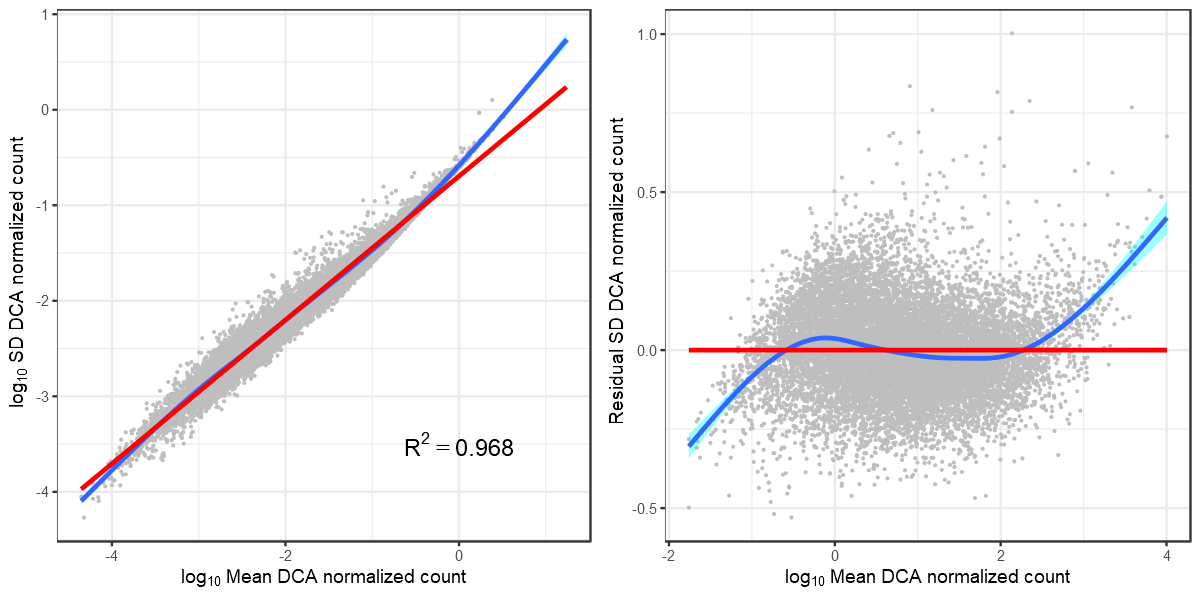

In [23]:
plot_left <- ggplot(meta, aes(x=log10(mean_dca), y=log10(sd_dca))) + 
             geom_point(color='gray', size=0.1) +
             geom_smooth(fill='cyan', size=1) + 
             geom_smooth(method=lm, color='red', fill='pink', size=1) +
             labs(x=expression(log[10]~'Mean DCA normalized count'), y=expression(log[10]~'SD DCA normalized count')) +
             annotate('text', x=0, y=-3.5, label=expression(R^2==0.968), size=5) + 
             theme_bw()

plot_right <- ggplot(meta, aes(x=log10(mean_rpkm), y=rsd_rpkm)) + 
              geom_point(color='gray', size=0.1) + theme_bw() +
              geom_smooth(fill='cyan', size=1) + 
              geom_smooth(method=lm, color='red', fill='pink', size=1) +
              labs(x=expression(log[10]~'Mean DCA normalized count'), y='Residual SD DCA normalized count') 

ggarrange(plot_left, plot_right)

In [24]:
# Get expression levels (mean DCA normalized counts) in different groups
noise_background <- mir2meta_var(mirna[mirna_mean > min_expression & mirna_mean <= -12, 1], 'mean_dca')
noise_LE_mirna <- mir2meta_var(mirna[mirna_mean > -12 & mirna_mean <= -9, 1], 'mean_dca')
noise_ME_mirna <- mir2meta_var(mirna[mirna_mean > -9 & mirna_mean <= -6, 1], 'mean_dca')
noise_HE_mirna <- mir2meta_var(mirna[mirna_mean > -6, 1], 'mean_dca')

# Get expression noises (RCV DCA normalized counts) in different groups
noise_background <- mir2meta_var(mirna[mirna_mean > min_expression & mirna_mean <= -12, 1], 'rsd_dca')
noise_LE_mirna <- mir2meta_var(mirna[mirna_mean > -12 & mirna_mean <= -9, 1], 'rsd_dca')
noise_ME_mirna <- mir2meta_var(mirna[mirna_mean > -9 & mirna_mean <= -6, 1], 'rsd_dca')
noise_HE_mirna <- mir2meta_var(mirna[mirna_mean > -6, 1], 'rsd_dca')

# The number of miRNAs and target mRNAs in each group.
group_size <- data.frame(mirna_expression=c('background','LE','ME','HE'), 
              mirna_number=c(sum(mirna_mean > min_expression & mirna_mean <= -12), sum(mirna_mean > -12 & mirna_mean <= -9), sum(mirna_mean > -9 & mirna_mean <= -6), sum(mirna_mean > -6)),
              target_number=c(length(noise_background), length(noise_LE_mirna), length(noise_ME_mirna), length(noise_HE_mirna)))
              
# In this dataframe, each row contains the group of a target mRNA, its expression level and expression noise. 
meta_var_df <- data.frame(group=rep(group_size$mirna_expression, group_size$target_number),
                          level=c(level_background, level_LE_mirna, level_ME_mirna, level_HE_mirna),
                          noise=c(noise_background, noise_LE_mirna, noise_ME_mirna, noise_HE_mirna))
                       
p_df <- data.frame(x=c('background','background','background','LE','LE','ME'),
                   y=c('LE','ME','HE','ME','HE','HE'),
                   p_level=c(ks.test(level_background, level_LE_mirna)$p.value,
                             ks.test(level_background, level_ME_mirna)$p.value,
                             ks.test(level_background, level_HE_mirna)$p.value,
                             ks.test(level_LE_mirna, level_ME_mirna)$p.value,
                             ks.test(level_LE_mirna, level_HE_mirna)$p.value,
                             ks.test(level_ME_mirna, level_HE_mirna)$p.value),
                   p_noise=c(ks.test(noise_background, noise_LE_mirna)$p.value,
                             ks.test(noise_background, noise_ME_mirna)$p.value,
                             ks.test(noise_background, noise_HE_mirna)$p.value,
                             ks.test(noise_LE_mirna, noise_ME_mirna)$p.value,
                             ks.test(noise_LE_mirna, noise_HE_mirna)$p.value,
                             ks.test(noise_ME_mirna, noise_HE_mirna)$p.value))

kruskal.test(level ~ group, data = meta_var_df) 
kruskal.test(noise ~ group, data = meta_var_df) 


	Kruskal-Wallis rank sum test

data:  level by group
Kruskal-Wallis chi-squared = 44.433, df = 3, p-value = 1.221e-09



	Kruskal-Wallis rank sum test

data:  noise by group
Kruskal-Wallis chi-squared = 41.36, df = 3, p-value = 5.486e-09


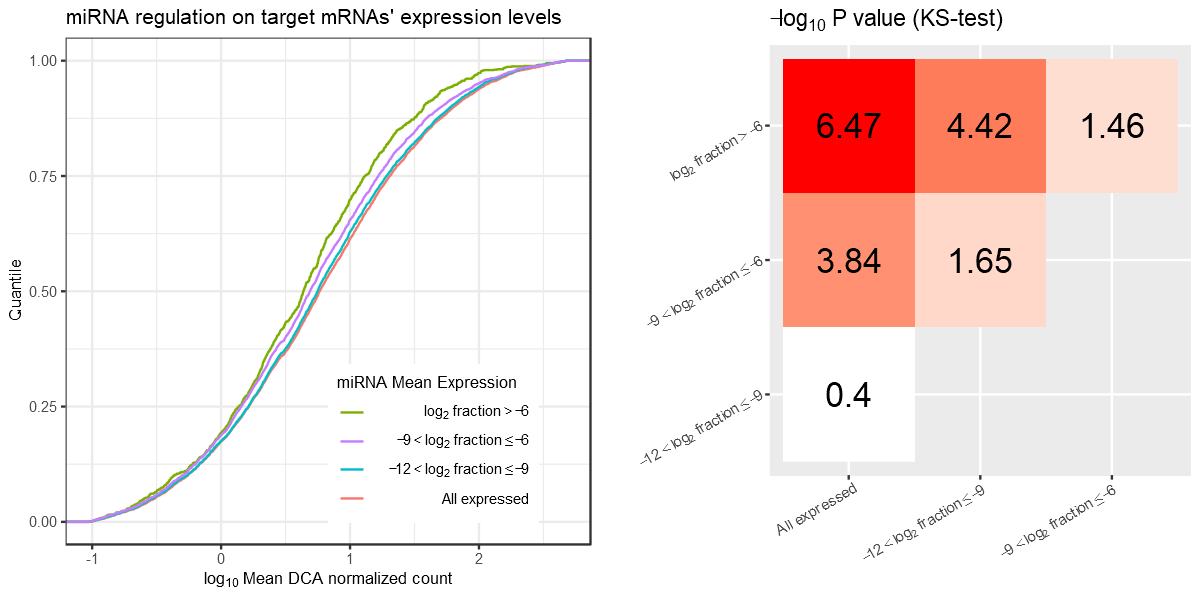

In [25]:
plot_ecdf <- ggplot(meta_var_df, aes(x=log10(level), color=group)) + 
             stat_ecdf(geom = "step") + 
             lims(x=quantile(log10(meta_var_df$level), c(0.01,0.99))) + 
             labs(x=expression(log[10]~'Mean DCA normalized count') ,y='Quantile', title="miRNA regulation on target mRNAs' expression levels") + 
             scale_color_discrete(breaks=c('HE','ME','LE','background'), 
                                  name='miRNA Mean Expression',
                                  labels=expression(log[2]~fraction > -6, -9 < log[2]~fraction <= -6, -12 < log[2]~fraction <= -9, 'All expressed')) + 
             theme_bw() + 
             theme(legend.position=c(0.7,0.2), title=element_text(size=10))
    
plot_p <- ggplot(p_df,aes(x=x,y=y)) + 
          geom_raster(aes(fill = -log10(p_level))) + 
          geom_text(aes(label = round(-log10(p_level),2)), size=7) + 
          scale_fill_gradient(low = "white", high = "red") + 
          scale_x_discrete(limits=c('background','LE','ME'), labels=expression('All expressed', -12 < log[2]~fraction <= -9, -9 < log[2]~fraction <= -6)) + 
          scale_y_discrete(limits=c('LE','ME','HE'), labels=expression(-12 < log[2]~fraction <= -9, -9 < log[2]~fraction <= -6, log[2]~fraction > -6)) +
          labs(x='',y='',title=expression(-log[10]~'P value (KS-test)')) + 
          theme(legend.position = 'none', axis.text = element_text(angle=30, hjust=1))
          
ggarrange(plot_ecdf, plot_p)

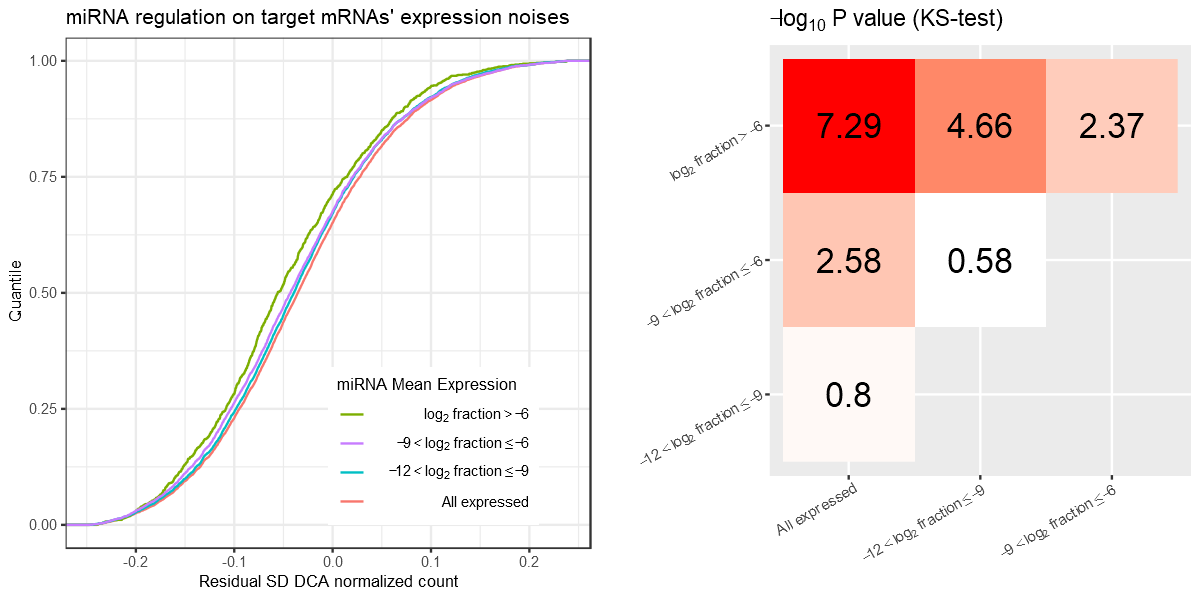

In [26]:
plot_ecdf <- ggplot(meta_var_df, aes(x=noise, color=group)) + 
             stat_ecdf(geom = "step") + 
             lims(x=quantile(meta_var_df$noise, c(0.01,0.99))) + 
             labs(x='Residual SD DCA normalized count' ,y='Quantile', title="miRNA regulation on target mRNAs' expression noises") + 
             scale_color_discrete(breaks=c('HE','ME','LE','background'), 
                                  name='miRNA Mean Expression',
                                  labels=expression(log[2]~fraction > -6, -9 < log[2]~fraction <= -6, -12 < log[2]~fraction <= -9, 'All expressed')) + 
             theme_bw() + 
             theme(legend.position=c(0.7,0.2), title=element_text(size=10))
    
plot_p <- ggplot(p_df,aes(x=x,y=y)) + 
          geom_raster(aes(fill = -log10(p_noise))) + 
          geom_text(aes(label = round(-log10(p_noise),2)), size=7) + 
          scale_fill_gradient(low = "white", high = "red") + 
          scale_x_discrete(limits=c('background','LE','ME'), labels=expression('All expressed', -12 < log[2]~fraction <= -9, -9 < log[2]~fraction <= -6)) + 
          scale_y_discrete(limits=c('LE','ME','HE'), labels=expression(-12 < log[2]~fraction <= -9, -9 < log[2]~fraction <= -6, log[2]~fraction > -6)) +
          labs(x='',y='',title=expression(-log[10]~'P value (KS-test)')) + 
          theme(legend.position = 'none', axis.text = element_text(angle=30, hjust=1))
          
ggarrange(plot_ecdf, plot_p)

Compared with the results obtained from RPKM values, more significant difference in expression noises among different groups is observed when using DCA normalized counts. Besides, expression noises between any two groups also become more significantly different. These results further support that **miRNAs regulate their target mRNAs by reducing their expression levels and noises**. 

<h2 id="5"> 5 Session Information </h2>

In [27]:
sessionInfo()

R version 3.6.0 (2019-04-26)
Platform: x86_64-w64-mingw32/x64 (64-bit)
Running under: Windows 10 x64 (build 17763)

Matrix products: default

locale:
[1] LC_COLLATE=Chinese (Simplified)_China.936 
[2] LC_CTYPE=Chinese (Simplified)_China.936   
[3] LC_MONETARY=Chinese (Simplified)_China.936
[4] LC_NUMERIC=C                              
[5] LC_TIME=Chinese (Simplified)_China.936    

attached base packages:
[1] stats     graphics  grDevices utils     datasets  methods   base     

other attached packages:
[1] ggpubr_0.2.1  magrittr_1.5  ggplot2_3.2.0

loaded via a namespace (and not attached):
 [1] Rcpp_1.0.1       pillar_1.3.1     compiler_3.6.0   base64enc_0.1-3 
 [5] tools_3.6.0      digest_0.6.18    uuid_0.1-2       jsonlite_1.6    
 [9] evaluate_0.13    tibble_2.1.1     gtable_0.3.0     nlme_3.1-139    
[13] lattice_0.20-38  mgcv_1.8-28      pkgconfig_2.0.2  rlang_0.4.0     
[17] Matrix_1.2-17    IRdisplay_0.7.0  IRkernel_0.8.15  repr_0.19.2     
[21] withr_2.1.2      dplyr_0.8.0.1